In [245]:
import numpy as np
import json
import matplotlib.pyplot as plt
import sippy
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import control.matlab as ctrl
import datetime
import pickle

# Load data
Load measured step response data

In [246]:
with open('response_1.json') as json_file:
    data = json.load(json_file)
n_points = len(data)
data[0:3]
# data[-1]

[{'ts': '2020-08-25 10:55:02',
  't': 0,
  'duty': 100,
  'T_boiler': 25.970787048339844},
 {'ts': '2020-08-25 10:55:03',
  't': 1,
  'duty': 100,
  'T_boiler': 25.995746612548828},
 {'ts': '2020-08-25 10:55:11',
  't': 9,
  'duty': 0,
  'T_boiler': 26.837848663330078}]

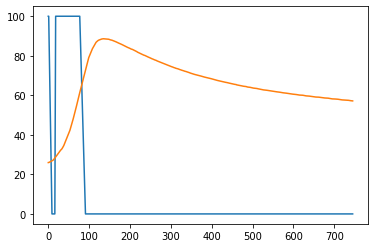

In [247]:
data_array = np.zeros((n_points, 3))

for index, item in enumerate(data):
    data_array[index, 0] = item["t"]
    data_array[index, 1] = item["duty"]
    data_array[index, 2] = item["T_boiler"]
# data_array
plt.plot(data_array[:,0], data_array[:,1])
plt.plot(data_array[:,0], data_array[:,2])

## Trim
Trim to start at 0 duty

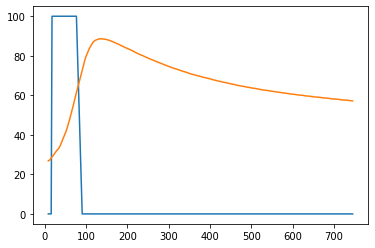

In [248]:
data_array = data_array[2:, :]
plt.plot(data_array[:,0], data_array[:,1])
plt.plot(data_array[:,0], data_array[:,2])

## Interpolate Data
Resample at fixed time interval

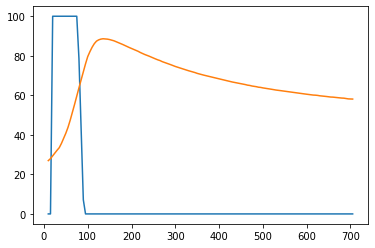

In [249]:
t_sample = 5
t = np.arange(10, 710, t_sample)
u = np.interp(t, data_array[:,0].reshape((1,-1))[0], data_array[:,1].reshape((1,-1))[0])
y = np.interp(t, data_array[:,0].reshape((1,-1))[0], data_array[:,2].reshape((1,-1))[0])
plt.plot(t, u)
plt.plot(t, y)

## Create Data Structure
Create data structure to save for future use

In [250]:
data_dict = {
    "date": datetime.date(2020, 8, 25),
    "t": t,
    "u": u,
    "y": y
}
with open('dataset_01.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data_dict, f, pickle.HIGHEST_PROTOCOL)

# Fit model
## System identification

In [265]:
method = "PARSIM-K"
sys_id = sippy.system_identification(y, u, method, IC="BIC", SS_orders=[1,5], tsample=t_sample)
print(sys_id.G)

The suggested order is: n= 5
A = [[ 1.10189199  0.08756231  0.03471794  0.00823607  0.00424503]
 [-4.09693856 -0.24733095  0.14734936 -0.11188929  0.03396869]
 [ 0.11417498 -0.28881237  0.7497506   0.11394154 -0.08153552]
 [ 0.85999822  0.26372529 -0.06455007  1.03068935  0.0379194 ]
 [ 2.82706166  0.55733389 -0.15689427  0.09279683  0.70757811]]

B = [[ 3.13408205e-05]
 [-4.58885976e-04]
 [-2.65294073e-03]
 [-3.33567811e-03]
 [ 1.10146131e-02]]

C = [[-88.28132067  -3.49843534   2.31804307  -1.94898734   0.36235499]]

D = [[0.]]

dt = 5



## State - space model

In [266]:
# Can format using control library, same output as sys_id.G
ss_model = ctrl.ss(sys_id.A, sys_id.B, sys_id.C, sys_id.D, t_sample)
ss_model

A = [[ 1.10189199  0.08756231  0.03471794  0.00823607  0.00424503]
 [-4.09693856 -0.24733095  0.14734936 -0.11188929  0.03396869]
 [ 0.11417498 -0.28881237  0.7497506   0.11394154 -0.08153552]
 [ 0.85999822  0.26372529 -0.06455007  1.03068935  0.0379194 ]
 [ 2.82706166  0.55733389 -0.15689427  0.09279683  0.70757811]]

B = [[ 3.13408205e-05]
 [-4.58885976e-04]
 [-2.65294073e-03]
 [-3.33567811e-03]
 [ 1.10146131e-02]]

C = [[-88.28132067  -3.49843534   2.31804307  -1.94898734   0.36235499]]

D = [[0.]]

dt = 5

In [267]:
# Simulate with SIPPY library
xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, u.reshape((1, -1)), sys_id.x0)

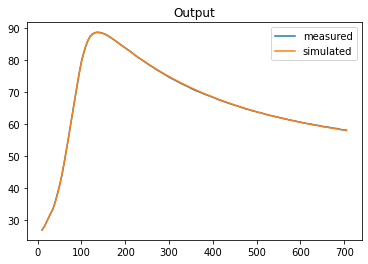

In [268]:
plt.plot(t, y, label="measured")
plt.plot(t, yid[0], label="simulated")
plt.title("Output")
plt.legend()

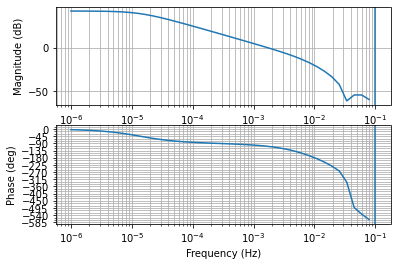

In [269]:
# Bode Plot
mag, phase, omega = ctrl.bode(sys_id.G)

# Analyse

## Controllability

In [270]:
cm = ctrl.ctrb(sys_id.A, sys_id.B)

In [271]:
order = cm.shape[0]
np.linalg.matrix_rank(cm) == order

True

## Step Response

array([-1.00283665,  2.75650929, -5.71281564, -3.28102317,  1.98846552])

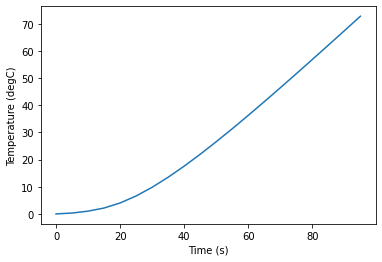

In [278]:
t_sim = np.arange(0, 100, t_sample)
u_sim = t_sim * 0 + 100
x0 = 0
y_step, t_step, x_step = ctrl.lsim(ss_model, u_sim, t_sim, X0=x0)
plt.plot(t_step, y_step)
plt.ylabel("Temperature (degC)")
plt.xlabel("Time (s)")
x_step[-1, :]

Text(0.5, 0, 'Time (s)')

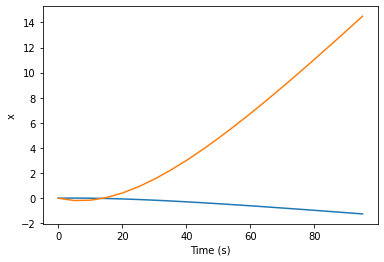

In [259]:
plt.plot(t_step, x_step)
plt.ylabel("x")
plt.xlabel("Time (s)")

# Control
## Ideal Controller

In [260]:
## Design LQR Controller
Q = np.eye(order)
R = 0.0001

K = ctrl.lqr(sys_id.A, sys_id.B, Q, R)[0]